In [1]:
%run 'Functions.ipynb'

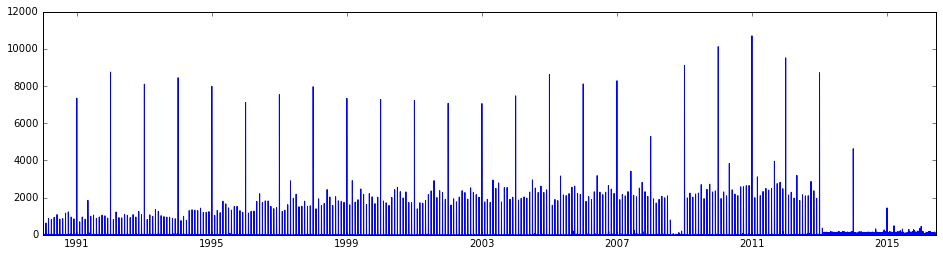

In [2]:
x, y = unzip(hist_data(None, '1990-01-01', '2017-01-01'))
plt.plot(x, y)